<div class="alert alert-success">
Este notebook de ipython depende del modulo `vis_int`, el cual es ilustrado en el notebook de [Visualización e Interacción](vis_int.ipybn).
</div>

In [1]:
from vis_int import *
import vis_int
print(dir(vis_int))

['Box', 'Button', 'FloatSlider', 'HTML', 'IntSlider', 'Latex', 'Markdown', 'Math', 'Text', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'clear_output', 'cos', 'discretizar', 'display', 'exp', 'fixed', 'graficar_autofuncion', 'graficar_autovalor', 'graficar_funcion', 'graficar_potencial', 'graficar_punto_texto', 'interact', 'interactive', 'link', 'log', 'pi', 'plt', 'potencial', 'sin', 'sqrt', 'tan']


# Técnicas Numéricas

Para el desarrollo de los modelos expuestos en los cursos de mecánica cuántica y física moderna, se recurre frecuentemente a funciones especiales y técnicas de solución matemáticas que en su operatividad pueden distraer el objetivo del curso y el adecuado entendimiento de los conceptos físicos en medio de las herramientas matemáticas.  

Con esto en mente, el uso de técnicas numéricas simples puede apoyar significativamente el desarrollo de los cursos, teniendo como ventaja la reducción a formas matemáticas simples (los métodos numéricos llevan a aproximaciones con operaciones aritmeticas) y funciones simples (las funciones se aproximan a funciones mucho más simples, generalmente polinomios). Esta reducción facilita además reducir a una sola técnica multiples desarrollos, ya que las diferencias no van tanto en los detalles del modelo original (como si dependen las soluciones análiticas) sino en los detalles del tipo de aproximación general.

Se exponen las soluciones numéricas de los siguientes problemas, útiles para el desarrollo de problemas 1D de mecánica cuántica.  
1. Búsqueda de raíces.  
  + Bisección.  
  + Incremental.  
1. Ecuaciones diferenciales con valores de frontera.  
  + Método del disparo con algoritmo Numerov.  
1. Adimensionalización.  
  + Unidades atomicas de Rydberg.  

## Búsqueda de raíces  

Los problemas de búsquedas de raíces corresponden a encontrar valores que al evaluarse en la función de interes generan como evaluación el valor cero. En la mecánica cuántica nos encontramos con la particularidad de requerir el calculo de raíces para determinar los autovalores de energía de un sistema en su planteamiento continuo (representación en el espacio directo). En estos sistemas de interes, de estados ligados, la energía del sistema se encuentra entre el mínimo y el máximo de la energía potencial a la que se encuentra sometido en el espacio, $$ V_{mín} \leq E_n \leq V_{máx}.$$  
En caso de ser el máximo $V_{máx} \rightarrow \infty$, el sistema posee infinitos autovalores que se encuentran con la condición $V_{mín} \leq E_n$.  

Para cualquiera de los casos, se presenta un interes en encontrar estos autovalores de manera ordenada, y esto lleva seleccionar los métodos de búsqueda cerrados por encima de los métodos de búsquedas abiertos, ya que en estos últimos la selección de un valor inicial no asegura la búsqueda en cercanías de este o en una dirección dada, por el contrario en los métodos cerrados se puede limitar la búsqueda a una región de la cual tenemos conocimiento que se presenta la raíz (autovalor de energía).  

El uso combinado entre el método de búsqueda incremental y el [método de bisección](https://en.wikipedia.org/wiki/Bisection_method), con un paso adecuado de energía, permite cumplir con el objetivo de hallar todos los autovalores (cuando los límites de energía son finitos) del sistema de forma ordenada, y con precisión arbitraria (limitada solo por la precisión de máquina). Para ello se inicia en el intervalo de búsqueda con el método de búsqueda incremental, el cual al encontrar un intervalo candidato a raíz (un intervalo que presenta cambio de signo entre sus extremos), refina el resultado mediante la aplicación del método de bisección en el intervalo candidato.  
Forma iterativa de búsqueda incremental $ E_{i+1} = E_i + \Delta E $.  
Forma iterativa de bisección $ E_{i+1} = \frac{E_i + E_{i-1}}{2}$.  

In [2]:
def biseccion(funcion, a, b, tol_x = 1e-6, factor_ty = 1e2):
    f0 = funcion(a)
    f1 = funcion(b)
    if abs(f0) < tol_x: # Se verifica que los extremos sean raices
        return a
    elif abs(f1) < tol_x:
        return b
    else: # Si los extremos no son raices, se bisecta.
        c = (a + b) / 2.0
        f2 = funcion(c)
        while abs(f2) >= tol_x and abs(c - b) >= tol_x:
            if f2 * f0 < 0 :
                b = c
                f1 = f2
            else:
                a = c
                f0 = f2
            c = (a + b) / 2.0
            f2 = funcion(c)
        if abs(f2) < tol_x * factor_ty: # Se verifica que efectivamente sea raiz
            return c
        else: # En caso de ser asintota vertical con cambio de signo
            return None

def incremental(funcion, a, b, delta_x = 1e-4, tol_x = 1e-6):
    c0 = a
    f0 = funcion(c0)
    c1 = c0 + delta_x
    c = None
    while c == None and c1 <=b: # Si no se ha hallado raíz y se esta en el intervalo, avance
        f1 = funcion(c1)
        while f0*f1 > 0 and c1 <= b:
            c0 = c1
            f0 = f1
            c1 = c1 + delta_x
            f1 = funcion(c1)
        if c1 > b: # Final del intervalo, equivalente f0*f1 > 0
            return None
        else: # Sub-intervalo con cambio de signo
            c = biseccion(funcion, c0, c1, tol_x) # Se invoca bisección para mejorar aproximación
            if c == None: # Si el candidato era discontinuidad, incremental avanza
                c0 = c1
                f0 = f1
                c1 = c1 + delta_x
    return c

Se observa en la implementación del método de bisección, que se considera una revisión extra a los códigos tradicionales, con el fin de validad si el candidato a raíz realmente lo es. Esto se requiere ya que es posible que la función asociada a la discretización de la energía posea discontinuidades alrededor de las cuales presente cambio de signo.  
Notese que la teoría clásica de métodos numéricos indica que estos métodos se aplican para funciones continuas. En este caso que esperamos discontinuidades dadas por cambios de signo a causa de divergencias al infinito, se pueden remover sistematicamente notando que a medida que se converge al candidato a raíz (tamaño de intervalo menor que la tolerancia), la evaluación de la función en este valor es significativamente mayor a la tolerancia, y cada vez su evaluación es mayor a la anterior.  
\begin{equation}
E \in [E_i, E{i+1}] \wedge \Delta E \leq tol \wedge \begin{cases}
f(E) > tol, & \qquad\text{Discontinuidad}\\
f(E) \leq tol, & \qquad\text{Raíz (autovalor)}
\end{cases}
\end{equation}

Una vez se obtiene una raíz, el método de búsqueda incremental continua nuevamente avanzando hasta encontrar un próximo intervalo candidato, al cual vuelve a aplicarle el método de bisección para distinguir si es raíz o discontinuidad. Este proceso se continua hasta el límite superior para la energía, $V_{máx}$.  
Para la busqueda de un autovalor especifico, se requiere buscar todos los autovalores anteriores. De manera que se requiere de una función auxiliar que medie este progreso dada un modo. El caracter progresivo sobre las energías ofrece la ventaja sobre técnicas de autovalores, de la posibilidad de obtener los autovalores ordenados de manera natural.

In [3]:
def raiz_n(funcion, a, b, N, delta_x = 1e-4, tol_x = 1e-6):
    c0 = a
    cont_raiz = 0
    while c0 < b and cont_raiz < N:
        c = incremental(funcion, c0, b, delta_x, tol_x)
        if c == None: # Si incremental termina en 'None', no hay más raíces
            return None
        cont_raiz = cont_raiz + 1
        c0 = c + delta_x
    if cont_raiz == N:
        return c
    else:
        return None

A continuación se ilustra el uso de la técnica con la función trascendental del problema del pozo finito simetrico con paridad par, que en la forma adimensional corresponde a:  
$$ \sqrt{E} - \sqrt{V_0 - E} \tan\left( \frac{\sqrt{V_0 - E}a}{2} \right) = 0, $$  
con $a$ el ancho del pozo, $V_0$ es la profundidad del pozo (con referencia desde cero por convención).

<IPython.core.display.Latex object>

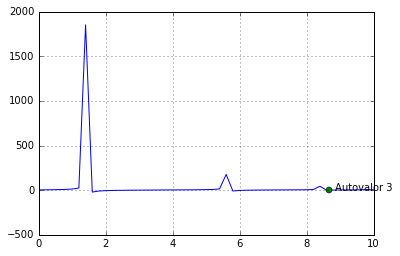

<function __main__.int_raiz_trasc>

In [4]:
def trascendental(E, V_0, a):
    k2 = sqrt(V_0 - E)
    return sqrt(E) - k2*tan(k2*a/2)

def int_raiz_trasc(V_0:(.1,20.,.1), a:(.1,15.,.1), N:(1, 6, 1), n:(1, 100, 1)):
    f = lambda E: trascendental(E, V_0, a)
    try:
        r = raiz_n(f, 0, V_0, N)
        E, tr = discretizar(f, 0, V_0, n)
        graficar_funcion(E, tr)
        graficar_punto_texto(r, 0, 'Autovalor ' + str(N))
        display(Latex('\(E_' + str(N) + '=' + str(r) + '\)'))
        plt.grid(True)
        plt.show()
        display(HTML('<div class="alert alert-warning">'+\
                     '<strong>Advertencia</strong> Alrededor de las discontinuidades'+\
                     ' el gráfico no es representado fielmente. </div>'))
    except ValueError:
        display(HTML('<div class="alert alert-danger">'+\
             '<strong>Error</strong> Se evaluo la función en una discontinuidad.'+\
             '</div>'))

interact(int_raiz_trasc)

## Ecuaciones diferenciales con problemas de frontera

La ecuación de Schrödinger, ya sea dependiente o independiente del tiempo, es una ecuación diferencial de segundo orden. Al remover la dependencia del tiempo y disponer de problemas 1D, se tiene que la ecuación diferencial es ordinaria. Para este tipo de ecuaciones (segundo orden, una variable) es posible aplicar métodos especificos que solución con bajo costo computacional aproximaciones de orden alto. Ejemplo de esto son los métodos de [Verlet](https://en.wikipedia.org/wiki/Verlet_integration) y de [Numerov](https://en.wikipedia.org/wiki/Numerov's_method), con método del disparo.

De la ecuación de Schrödinger se observa que si se reemplazan los valores por cantidades conocidas estimadas, el valor de la energía $E$ que cumple con ser autovalor, es aquel que haga satisfacer las condiciones de frontera del problema, y por ende una forma de solucionar el problema es mediante la aplicación de un problema de busqueda de raices. De esta forma, el método del disparo lo que hace es el ajuste de $E$ para que partiendo de una frontera, con la condicón respectiva, al propagarse hasta la otra frontera llegue con el valor de la otra condición. De no hacerlo, se cambio el valor de $E$ y se repite el proceso.

El esquema de Numerov para la propagación es, dada una ecuación diferencial ordinaria de segundo orden sin termino lineal, $$ \frac{d^2y(x)}{dx^2} + K(x)y(x) = 0, $$ su esquema discreto se plantea como $$ y_{i+2} = \frac{\left(2-\frac{5h^2 K_{i+2}}{6} \right)y_{i+1} - \left(1+\frac{h^2 K_{i}}{12} \right) y_i}{ \left(1+\frac{h^2 K_{i+2}}{12} \right)}. $$

Para nuestro caso, la función $K(x)$ posee dependencia de la energía, y todos los demás elementos son conocidos (la función solución, de onda en este caso, se construye iterativamente dado un valor de energía), por lo cual se puede definir una función que dada una energía como argumento, genere el valor de la función de onda en la frontera opuesta. Este valor en la frontera, por las condiciones establecidas por los potenciales y la condición de integrabilidad, debe ser $\psi(x_{izq}) = \psi(x_{der}) = 0$.

Tambien es usual usar como definición de la función, la diferencia de las derivadas logaritmicas en un punto intermedio, realizando la propagación desde ambos extremos. Por facilidad, se optará por la metodología clásica del disparo, que ofrece menor cantidad de operaciones y no presenta ambigüedades de definición, que consta de comparar con el valor esperado en la frontera opuesta, $Numerov(E) = 0$.

Este problema de búsqueda de raíces requiere conocer dos condiciones iniciales, la segunda debe tomarse acorde a la paridad de la energía buscada. Para paridad par, el segundo valor es positivo, mientras que para paridad impar el segundo valor es negativo.  

La función `estacionario` se define para buscar el punto de empate adecuado para el análisis de la continuidad de la función de onda y su derivada. Como criterio, se buscan los _turning points_ clásicos, donde $E=V(x)$.

In [5]:
def estacionario(K, L, h):
    x = -L/2
    while x < L/2 and K(x) <= 0:
        x = x + h
    if x >= L/2:
        return L/2
    elif x == -L/2:
        return -L/2
    else:
        return x - h

def numerov(K_ex, L, E, N, n):
    h = L / n
    K = lambda x: K_ex(E, x)
    p_est = estacionario(K, L, h)
    x = -L/2
    phi0 = 0.0
    x = x + h
    phi1 = 1e-10
    x = x + h
    while x <= p_est :
        term0 = 1 + h**2 * K(x - h) / 12
        term1 = 2 - 5 * h**2 * K( x) / 6
        term2 = 1 + h**2 * K(x + h) / 12
        aux = phi1
        phi1 = (term1 * phi1 - term0 * phi0) / term2
        phi0 = aux
        x = x + h
    phi_i_1 = phi1
    phi_i_0 = phi0
    x = L/2
    phi0 = 0.0
    x = x - h
    phi1 = 1e-10 * (-1)**(N%2 + 1)
    x = x - h
    while x > p_est :
        term0 = 1 + h**2 * K(x + h) / 12
        term1 = 2 - 5 * h**2 * K(x) / 6
        term2 = 1 + h**2 * K(x - h) / 12
        aux = phi1
        phi1 = (term1 * phi1 - term0 * phi0) / term2
        phi0 = aux
        x = x - h
    phi_d_1 = phi_i_1 
    phi_d_0 = phi0 * phi_i_1 / phi1 
    return (2*phi_d_1 - (phi_i_0+phi_d_0)) / (phi_d_0 - phi_i_0)


def Phi(K_ex, L, E, N, n):
    h = L / n
    K = lambda x: K_ex(E, x)
    p_est = estacionario(K, L, h)
    x = -L/2
    x_g = [x]
    phi0 = 0.0
    phi_g = [phi0]
    x = x + h
    phi1 = 1e-10
    x_g.append(x)
    phi_g.append(phi1)
    x = x + h
    while x <= p_est:
        term0 = 1 + h**2 * K(x - h) / 12
        term1 = 2 - 5 * h**2 * K(x) / 6
        term2 = 1 + h**2 * K(x + h) / 12
        aux = phi1
        phi1 = (term1 * phi1 - term0 * phi0) / term2
        x_g.append(x)
        phi_g.append(phi1)
        phi0 = aux
        x = x + h
    x = L/2
    phi0 = 0.0
    x_gd = [x]
    phi_gd = [phi0]
    x = x - h
    phi1 = 1e-10 * (-1)**(N%2 + 1)
    x_gd.insert(0, x)
    phi_gd.insert(0, phi1)
    x = x - h
    while x > p_est:
        term0 = 1 + h**2 * K(x + h) / 12
        term1 = 2 - 5 * h**2 * K(x) / 6
        term2 = 1 + h**2 * K(x - h) / 12
        aux = phi1
        phi1 = (term1 * phi1 - term0 * phi0) / term2
        x_gd.insert(0, x)
        phi_gd.insert(0, phi1)
        phi0 = aux
        x = x - h
    n_d = len(phi_gd)
    phi_gd = [phi_gd[i] * phi_g[-1] / phi1 for i in range(n_d)]
    x_g.extend(x_gd)
    phi_g.extend(phi_gd)
    return x_g, phi_g

Para la ecuación de Schrödinger, $K(x) = E - V(x)$.  

In [6]:
def K_Schr(V_0, a):
    return lambda e, x: e - potencial(V_0, a, x)

Para ilustrar el método del disparo, se presenta el siguiente control. La idea es ajustar para una configuración de potencial $V_0$, ancho $a$, longitud total $L$ y numero de elementos de discretización $n$, la energía $E$ adecuada para observar continuidad en la función de onda y su derivada en todo el intervalo. Dada la implementación del método se verifica dicha continuidad en el limite de la primera pared. Más adelante se define de manera general como seleccionar el punto de comparación.  

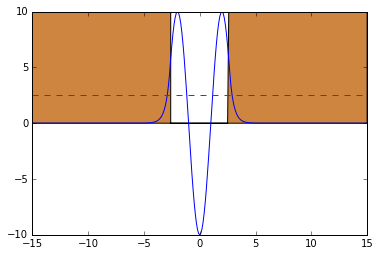

<function __main__.disparo>

In [7]:
def disparo(V_0, a,  L, n, N, E):
    x, phi = Phi(K_Schr(V_0, a), L, E, N, n)
    V = [potencial(V_0, a, i) for i in x]
    graficar_potencial(x, V)
    graficar_autofuncion(x, phi, V_0)
    graficar_autovalor(L, E)
    plt.show()
    
def presion_disparo(boton):
    disparo(V_0, a.value,  L, n.value, N, E.value)

interact(disparo, V_0=(0., 20., .5), a=(.5, 10., .1), L=(10., 50., 5.), n=(100, 500, 50), N=fixed(1), E=(.0, 5., .01))

La anterior ilustración tambien permite observar los efectos del potencial sobre un paquete de onda cuando la energía es menor o mayor que el potencial. Se puede observar como para $E>V_0$, se obtiene una función de onda oscilante en todo el intervalo, equivalente a una particula libre.  

Se define la función `E_N` para el calculo de las autoenergías, que pueden incluirse en la función `Phi` para generar las autofunciones. Esta función puede explorarse en el notebook de [Estados ligados](estados_ligados.ipynb).  

In [8]:
def E_N(K, E_max, L, N, n, delta_e = 1e-4, tol_e = 1e-6):
    Numerov = lambda e: numerov(K, L, e, N, n)
    return raiz_n(Numerov, tol_e, E_max, N, delta_e, tol_e)

In [9]:
def Solve_Schr(Vx, E_max, L, N, n):
    x_vec, V_vec = discretizar(Vx, -L/2, L/2, n)
    V_min = min(V_vec)
    K = lambda e, x : e - Vx(x) + V_min
    E = E_N(K, E_max - V_min, L, N, n)
    if E != None:
        x_vec, phi = Phi(K, L, E, N, n)
        E = E + V_min
        display(Latex('\(E_{' + str(N) + '} = ' + str(E) + '\)'))
        V_vec = [Vx(i) for i in x_vec]
        graficar_potencial(x_vec, V_vec)
        V_max = max(V_vec)
        V_ref = max(abs(V_min), V_max)
        graficar_autofuncion(x_vec, phi, V_ref)
        graficar_autovalor(L, E)
        plt.show()
        return E, x_vec, phi
    else:
        display(HTML('<div class="alert alert-danger">'+\
             '<strong>Error</strong> Se evaluo la función en una discontinuidad.'+\
             '</div>'))

El siguiente bloque define la base de los controles, `fun_contenedor_base`, para el notebook conceptual, [Estados ligados](estados_ligados.ipynb), donde los parametros de máxima energía de búsqueda, longitud de interes, número de estado y particiones son comunes.  

In [10]:
def fun_contenedor_base():
    E_max = FloatSlider(value=10., min = 1., max=20., step=1., description= '$E_{max}$')
    L = FloatSlider(value = 30., min = 10., max = 100., step= 1., description='L')
    N = IntSlider(value=1, min=1, max= 6, step=1, description='N')
    n = IntSlider(value= 300, min= 100, max= 500, step=20, description='n')
    return Box(children=[E_max, L, N, n])

Contenedor_base = fun_contenedor_base()
display(Contenedor_base)

In [11]:
def agregar_control(base, control):
    controles = list(base.children)
    controles.append(control)
    base.children = tuple(controles)
    
control_prueba = fun_contenedor_base()
agregar_control(control_prueba, Text(description='Casilla de texto para prueba'))
display(control_prueba)

La función `agregar_control` permite agregar controles adicionales a la base para crear el control especifico de los casos de prueba.  

## Adimensionalización  

Para fines de la solución numérica, conviene definir las [unidades atomicas de Rydberg](http://home.agh.edu.pl/~bjs/ARU.pdf). El uso de estas unidades permite hacer comparables los ordenes de maginitud tan dispares que poseen las variables involucradas y así controlar el error numérico que pueda tener el algoritmo.  

$ \hbar = 2m_e = \frac{e^2}{2} = 1 $

Para fines de ilustración se considera que el problema se resuelve solo para electrones, de manera que el problema se hace independiente de la masa.  

La energía se mide en Rydbergs y las longitudes en radios de Bohr.  

$ 1\ Ry = 13.6\ eV, \qquad 1\ a_0 = 5.29 \cdot 10^{-11}\ m$  

Realizando las sustituciones correspondienes, la forma adimensional de la ecuación Schrödinger es.

$ - \frac{d^2 \psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x) $